# Age Classification of *Chen Pi* with ResNet50

Images are taken manually.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision.io import read_image
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
import numpy as np
import pandas as pd
import random
import os
import json

In [2]:
IMG_DIR = "./data_orange_peels/"
TRAIN_PROPORTION = 0.8
BATCH_SIZE = 32
NUM_EPOCHS = 5
LR = 0.001
IMAGE_SIZE = (3024, 4032)
SIZE_MODIFIER = 0.0625
RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]

In [3]:
encoder = {
    6 : 0,
    10 : 1,
    15 : 2,
    20 : 3,
}

decoder = { v:k for k,v in encoder.items()}

class OrangePeelsDataset(Dataset):
    def __init__(self, img_dir, class_size = None, transform = None, target_transform = None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # store paths and labels in DataFrame
        data = { "image_path" : [], "label" : [] }
        # for subdir in os.listdir(img_dir):
        #     for file in os.listdir(os.path.join(img_dir, subdir)):
        #         if file.startswith("IMG"):
        #             data["image_path"].append(os.path.join(img_dir, subdir, file))
        #             data["label"].append(int(subdir))
        
        for subdir in os.listdir(img_dir):
            files = [f for f in os.listdir(os.path.join(img_dir, subdir)) if f.startswith("IMG")]
            random.shuffle(files)
            for idx, file in enumerate(files):
                if class_size is not None:
                    if idx >= class_size:
                        break

                data["image_path"].append(os.path.join(img_dir, subdir, file))
                data["label"].append(int(subdir))

        self.annotations = pd.DataFrame(data).sample(frac = 1).reset_index(drop = True)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image = read_image(self.annotations.iloc[idx, 0]).float()
        label = encoder[self.annotations.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [4]:
def create_model(base_model, optimizer, num_classes = 4, device = None, learning_rate = LR):
    feature_extractor = nn.Sequential(*list(deepcopy(base_model).children())[:-1])
    model = nn.Sequential(
        feature_extractor,
        nn.Flatten(),
        nn.Linear(2048, num_classes)
    )

    if device is not None:
        model = model.to(device)
    
    optimizer = optimizer(model.parameters(), lr = learning_rate)

    return model, optimizer

def train_model(model, loader, optimizer, criterion, device = None, epochs = NUM_EPOCHS, stats = False):
    model.train()
    losses = []
    accuracies = []
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(loader):
            if device is not None:
                images = images.to(device)
                labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            accuracies.append((outputs.argmax(1) == labels).float().mean().item()) # running accuracy

        if stats:
            print(f"Epoch {epoch + 1} / {epochs} : Loss = {losses[-1]:.4f}, Accuracy = {accuracies[-1]:.4f}")

    return losses, accuracies

def test_model(model, loader, device = None):
    predictions = torch.tensor([], dtype = torch.long).to(device)
    true = torch.tensor([], dtype = torch.long).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            if device is not None:
                images = images.to(device)
                labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions = torch.cat((predictions, predicted))
            true = torch.cat((true, labels))

    return predictions, true

def get_average_auc(predict, actual, num_classes = 4):
    aucs = []
    for i in range(num_classes):
        i_predict = predict == i
        i_actual = actual == i
        aucs.append(metrics.roc_auc_score(i_actual, i_predict))

    return np.mean(aucs), aucs

In [5]:
transform = transforms.Compose([
    transforms.Resize((int(SIZE_MODIFIER*IMAGE_SIZE[0]), int(SIZE_MODIFIER*IMAGE_SIZE[1]))),
    transforms.Normalize(mean = RESNET_MEAN, std = RESNET_STD),
    transforms.RandomRotation(30)
])

inverse_transform = transforms.Compose([
    transforms.Normalize(mean = [0., 0., 0.,], std = [1/sd for sd in RESNET_STD]),
    transforms.Normalize(mean = [-m for m in RESNET_MEAN], std = [1., 1., 1.]),
])

data = OrangePeelsDataset(IMG_DIR, class_size = 80, transform = transform)
print("Length:", len(data))

train, test = random_split(
    data,
    [
        int(0.8*len(data)),
        len(data) - int(0.8*len(data))
    ]
)

train_loader = DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)

Length: 320


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Shape: (189, 252, 3) (0.0625)


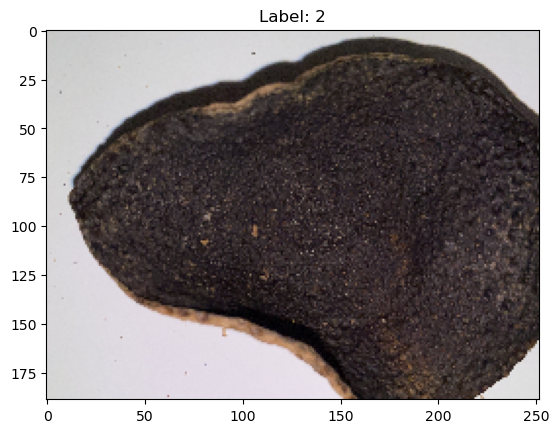

In [7]:
image = inverse_transform(data[random.randint(0, len(data))][0]).numpy().astype(np.int32).transpose(1, 2, 0)
plt.imshow(image)
plt.title(f"Label: {data[0][1]}")
print(f"Shape: {image.shape} ({SIZE_MODIFIER})")

In [8]:
resnet50 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained = True)

Using cache found in C:\Users\fongc/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
d = {}
skf = KFold(n_splits = 10, shuffle = True, random_state = 42)
for i, (train_idx, test_idx) in enumerate(skf.split(data.annotations["image_path"], data.annotations["label"])):
    key = f"fold_{i}"
    d[key] = {}

    train = Subset(data, train_idx)
    test = Subset(data, test_idx)
    train_loader = DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
    test_loader = DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)

    optimizer = torch.optim.Adam
    model, optimizer = create_model(resnet50, optimizer, device = device)
    criterion = nn.CrossEntropyLoss()
    losses, accuracies = train_model(model, train_loader, optimizer, criterion, device = device, stats = True)
    predictions, true = test_model(model, test_loader, device = device)
    auc = get_average_auc(predictions.cpu().numpy(), true.cpu().numpy())

    d[key]["losses"] = losses
    d[key]["accuracies"] = accuracies
    d[key]["predictions"] = predictions
    d[key]["true"] = true
    d[key]["auc"] = auc
    d[key]["accuracy"] = metrics.accuracy_score(true.cpu().numpy(), predictions.cpu().numpy())

Epoch 1 / 5 : Loss = 1.0084, Accuracy = 0.5625
Epoch 2 / 5 : Loss = 1.0054, Accuracy = 0.6875
Epoch 3 / 5 : Loss = 0.6080, Accuracy = 0.6875
Epoch 4 / 5 : Loss = 0.3944, Accuracy = 0.9062
Epoch 5 / 5 : Loss = 0.0509, Accuracy = 1.0000
Epoch 1 / 5 : Loss = 0.8776, Accuracy = 0.5625
Epoch 2 / 5 : Loss = 0.4827, Accuracy = 0.8750
Epoch 3 / 5 : Loss = 0.5728, Accuracy = 0.8125
Epoch 4 / 5 : Loss = 0.1636, Accuracy = 0.9688
Epoch 5 / 5 : Loss = 0.3254, Accuracy = 0.8750
Epoch 1 / 5 : Loss = 1.0453, Accuracy = 0.6250
Epoch 2 / 5 : Loss = 0.8904, Accuracy = 0.6875
Epoch 3 / 5 : Loss = 0.3593, Accuracy = 0.8438
Epoch 4 / 5 : Loss = 0.2117, Accuracy = 0.9062
Epoch 5 / 5 : Loss = 0.3137, Accuracy = 0.9688
Epoch 1 / 5 : Loss = 1.6053, Accuracy = 0.4062
Epoch 2 / 5 : Loss = 0.8193, Accuracy = 0.7188
Epoch 3 / 5 : Loss = 0.5608, Accuracy = 0.7812
Epoch 4 / 5 : Loss = 0.6869, Accuracy = 0.8125
Epoch 5 / 5 : Loss = 0.6245, Accuracy = 0.8125
Epoch 1 / 5 : Loss = 0.7377, Accuracy = 0.7188
Epoch 2 / 5 :

KeyboardInterrupt: 

In [13]:
print("Folds:", list(d.keys()))
print("Fold Keys:", list(d["fold_0"].keys()))

Folds: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5', 'fold_6', 'fold_7', 'fold_8', 'fold_9']
Fold Keys: ['losses', 'accuracies', 'predictions', 'true', 'auc', 'accuracy']


In [14]:
print("Average Accuracy:", np.mean([d[key]["accuracy"] for key in d.keys()]))

Average Accuracy: 0.621875


In [18]:
[(key, d[key]["accuracy"]) for key in d.keys()]

[('fold_0', 0.6875),
 ('fold_1', 0.75),
 ('fold_2', 0.75),
 ('fold_3', 0.53125),
 ('fold_4', 0.625),
 ('fold_5', 0.5625),
 ('fold_6', 0.78125),
 ('fold_7', 0.6875),
 ('fold_8', 0.375),
 ('fold_9', 0.46875)]

Fold Accuracy: 0.46875


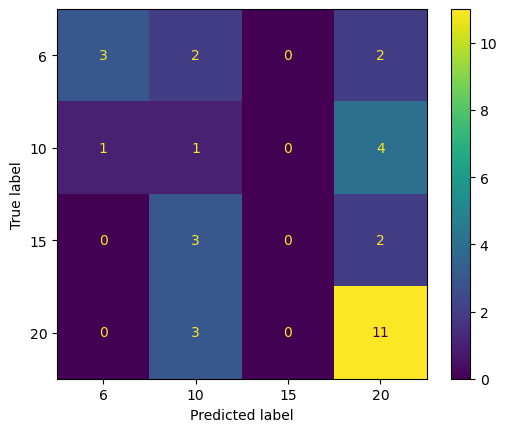

In [34]:
key = "fold_9"
matrix = metrics.ConfusionMatrixDisplay.from_predictions(
    d[key]["true"].cpu().numpy(),
    d[key]["predictions"].cpu().numpy(),
    display_labels = [6, 10, 15, 20]
)
print("Fold Accuracy:", metrics.accuracy_score(d[key]["true"].cpu().numpy(), d[key]["predictions"].cpu().numpy()))

In [ ]:
print("Unique labels:", true.unique())
auc_scores = []
for i in range(4):
    label_trues = true.cpu().numpy() == i
    label_predicts = predictions.cpu().numpy() == i

    auc_score = metrics.roc_auc_score(label_trues, label_predicts)
    print("\tAUC for label {} ({}): {}".format(
        decoder[i], i,
        auc_score
    ))
    auc_scores.append(auc_score)

print("Average AUC:", np.mean(auc_scores))

Unique labels: tensor([0, 1, 2, 3], device='cuda:0')
	AUC for label 6 (0): 0.875
	AUC for label 10 (1): 0.8541666666666666
	AUC for label 15 (2): 0.9166666666666666
	AUC for label 20 (3): 0.9375
Average AUC: 0.8958333333333333


Image Number: 6


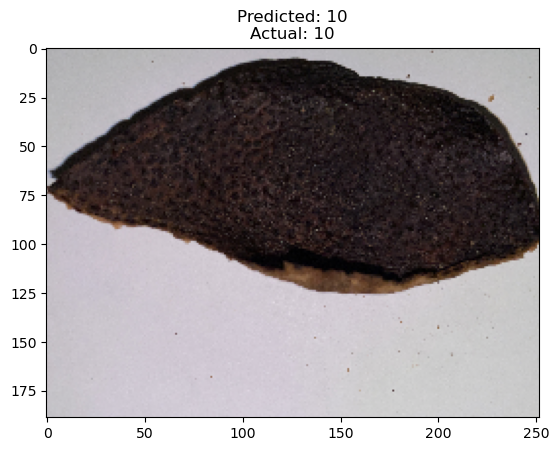

In [35]:
idx = np.random.randint(0, len(test))
sample_image = test[idx][0]
sample_label = test[idx][1]
print("Image Number:", idx)

with torch.no_grad():
    sample_predict = model(sample_image[None, :, :, :].to(device))
    _, sample_predict = torch.max(sample_predict.data, 1)

plt.imshow(inverse_transform(sample_image).numpy().astype(np.int32).transpose(1, 2, 0))
plt.title("Predicted: {}\nActual: {}".format(decoder[sample_predict.item()], decoder[sample_label]))
plt.show()

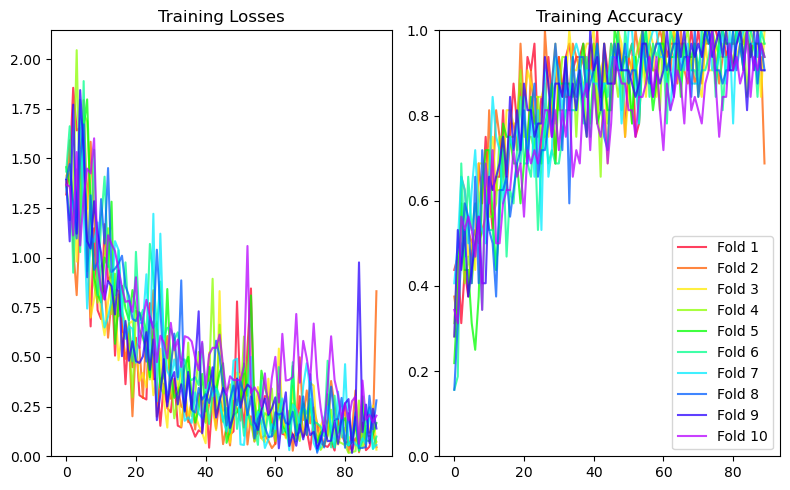

In [32]:
cmap = plt.get_cmap("gist_rainbow")
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
max_loss = -1
for i, k in enumerate(d.keys()):
    label = f"Fold {int(k.split('_')[1])+1}"
    color = cmap(i/len(d.keys()))
    if max(d[k]["losses"]) > max_loss:
        max_loss = max(d[k]["losses"])
    axes[0].plot(d[k]["losses"], label=label, color=color, alpha=0.75)
    axes[1].plot(d[k]["accuracies"], label=label, color=color, alpha=0.75)
axes[0].set_ylim([0, max_loss + 0.1])
axes[0].set_title("Training Losses")
axes[1].set_ylim([0, 1])
axes[1].set_title("Training Accuracy")
plt.tight_layout()
plt.legend()
plt.show()